In [94]:
import os
import pickle
import sys
import requests
from io import BytesIO
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [95]:
export_dir = "../model_exports"  # relative path to your notebook


# load the trained model
with open(os.path.join(export_dir, "stock_model.pkl"), "rb") as f:
    stocks_cv = pickle.load(f)
print("Trained model loaded:", type(stocks_cv))

# load pre-covid dataset
with open(os.path.join(export_dir, "X_test.pkl"), "rb") as f:
    X_test = pickle.load(f)
with open(os.path.join(export_dir, "y_test.pkl"), "rb") as f:
    y_test = pickle.load(f)
print("Pre-COVID evaluation data loaded.")

# load post-covid evaluation data
with open(os.path.join(export_dir, "X_post.pkl"), "rb") as f:
    X_post = pickle.load(f)
with open(os.path.join(export_dir, "y_post.pkl"), "rb") as f:
    y_post = pickle.load(f)
print("Post-COVID evaluation data loaded.")

Trained model loaded: <class 'sklearn.model_selection._search.GridSearchCV'>
Pre-COVID evaluation data loaded.
Post-COVID evaluation data loaded.


In [96]:
# Run grid search and store results in a DataFrame
cv_results = pd.DataFrame(stocks_cv.cv_results_)

# Inspect top rows
print(cv_results.head())

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.245247      0.031622         0.011087        0.000286   
1       0.581631      0.103735         0.022633        0.000369   
2       1.167163      0.203743         0.042839        0.000859   
3       0.229564      0.038855         0.010742        0.000207   
4       0.566421      0.098214         0.022624        0.000173   

   param_regressor__max_depth  param_regressor__min_samples_leaf  \
0                           5                                  5   
1                           5                                  5   
2                           5                                  5   
3                           5                                 10   
4                           5                                 10   

   param_regressor__n_estimators  \
0                            200   
1                            500   
2                           1000   
3                            200   
4       

In [97]:
# load the pre-processed CSV files

precovid_df = pd.read_csv('../data/precovid.csv')
postcovid_df = pd.read_csv('../data/postcovid.csv')

In [98]:
#Predictions and probabilities
y_test_proba = stocks_cv.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= threshold).astype(int)

y_post_proba = stocks_cv.predict_proba(X_post)[:, 1]
y_post_pred = (y_post_proba >= threshold).astype(int)

/var/folders/0t/3rqmkkps2tx4pjwf78xvy2xh0000gn/T/ipykernel_11074/1786841321.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')


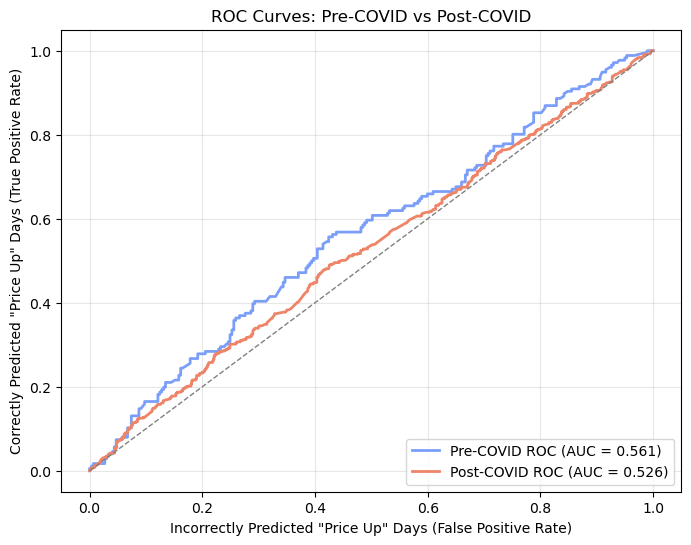

In [99]:
#ROC Curve
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
roc_auc_test = auc(fpr_test, tpr_test)

fpr_post, tpr_post, _ = roc_curve(y_post, y_post_proba)
roc_auc_post = auc(fpr_post, tpr_post)

#Generate colors from 'coolwarm' colormap
cmap = cm.get_cmap('coolwarm')
color_test = cmap(0.2)  # pick a value between 0 and 1
color_post = cmap(0.8)

plt.figure(figsize=(8,6))
plt.plot(fpr_test, tpr_test, color=color_test, lw=2, label=f'Pre-COVID ROC (AUC = {roc_auc_test:.3f})')
plt.plot(fpr_post, tpr_post, color=color_post, lw=2, label=f'Post-COVID ROC (AUC = {roc_auc_post:.3f})')
plt.plot([0,1], [0,1], color='grey', lw=1, linestyle='--')
plt.xlabel('Incorrectly Predicted "Price Up" Days (False Positive Rate)')
plt.ylabel('Correctly Predicted "Price Up" Days (True Positive Rate)')
plt.title('ROC Curves: Pre-COVID vs Post-COVID')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

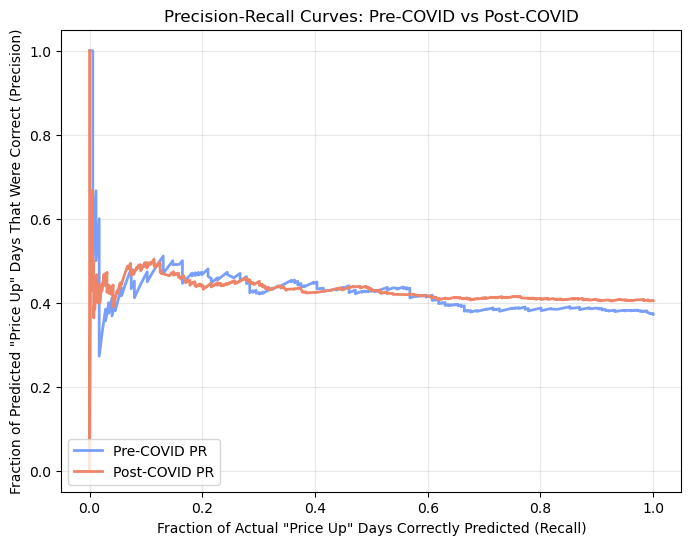

In [100]:
#Precision-Recall Curve

precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_proba)
precision_post, recall_post, _ = precision_recall_curve(y_post, y_post_proba)

plt.figure(figsize=(8,6))
plt.plot(recall_test, precision_test, color=color_test, lw=2, label='Pre-COVID PR')
plt.plot(recall_post, precision_post, color=color_post, lw=2, label='Post-COVID PR')
plt.xlabel('Fraction of Actual "Price Up" Days Correctly Predicted (Recall)')
plt.ylabel('Fraction of Predicted "Price Up" Days That Were Correct (Precision)')
plt.title('Precision-Recall Curves: Pre-COVID vs Post-COVID')
plt.legend(loc='lower left')
plt.grid(alpha=0.3)
plt.show()

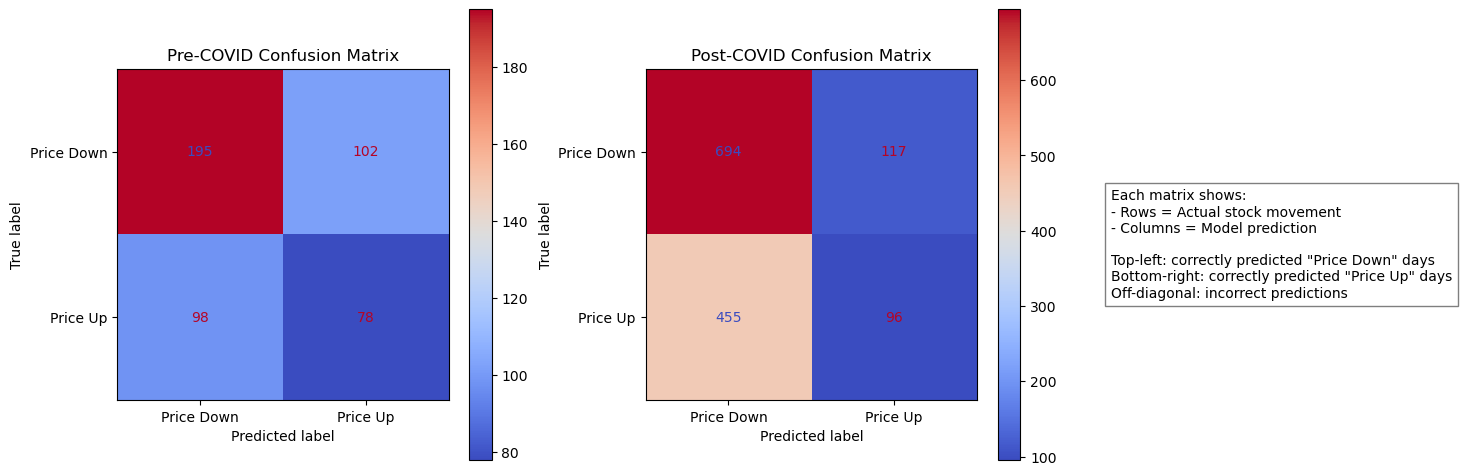

In [101]:
#Confusion Matrix Visualization
fig, axes = plt.subplots(1, 2, figsize=(12,5))

#Pre-COVID Confusion Matrix
cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Price Down', 'Price Up'])
disp_test.plot(ax=axes[0], cmap=cmap, values_format='d')
axes[0].set_title('Pre-COVID Confusion Matrix')

# Post-COVID Confusion Matrix
cm_post = confusion_matrix(y_post, y_post_pred)
disp_post = ConfusionMatrixDisplay(confusion_matrix=cm_post, display_labels=['Price Down', 'Price Up'])
disp_post.plot(ax=axes[1], cmap=cmap, values_format='d')
axes[1].set_title('Post-COVID Confusion Matrix')

#Add plain language explanations 
fig.text(0.93, 0.5,
         'Each matrix shows:\n'
         '- Rows = Actual stock movement\n'
         '- Columns = Model prediction\n\n'
         'Top-left: correctly predicted "Price Down" days\n'
         'Bottom-right: correctly predicted "Price Up" days\n'
         'Off-diagonal: incorrect predictions',
         fontsize=10, va='center', ha='left', bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout(rect=[0,0,0.9,1])  # leave space on right for the explanation box
plt.show()

/var/folders/0t/3rqmkkps2tx4pjwf78xvy2xh0000gn/T/ipykernel_11074/332630071.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(title='Actual Outcome')
/var/folders/0t/3rqmkkps2tx4pjwf78xvy2xh0000gn/T/ipykernel_11074/332630071.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(title='Actual Outcome')


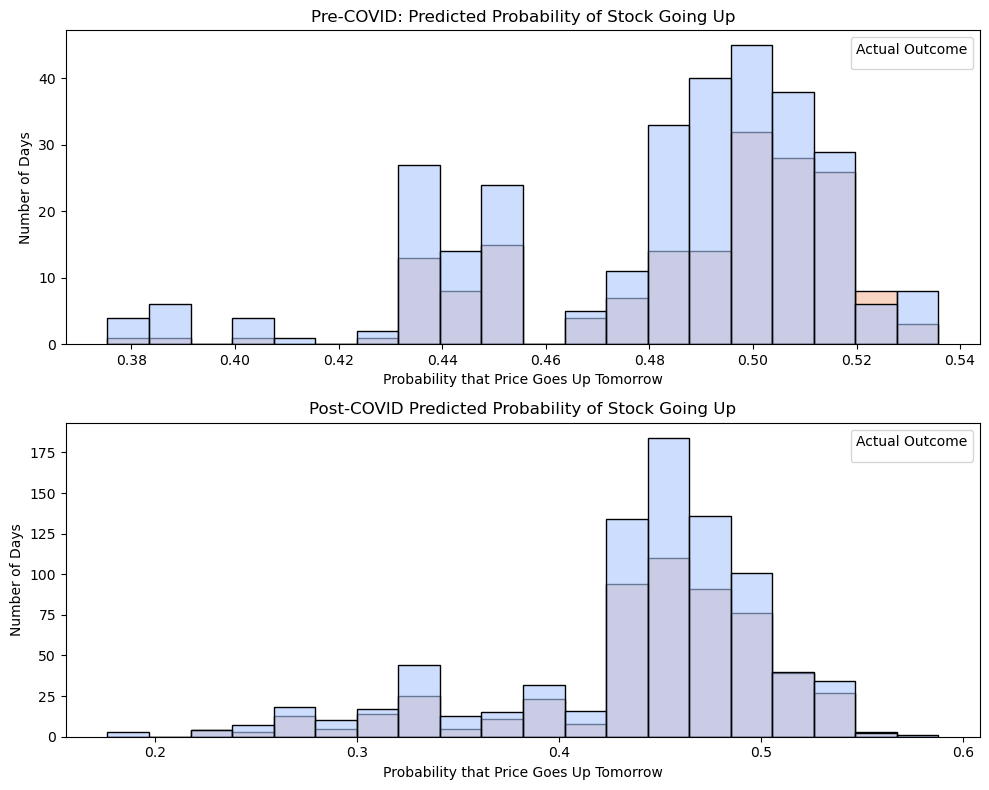

In [102]:
#Predicted probability histograms
fig, axes = plt.subplots(2, 1, figsize=(10,8))

# Pre-COVID
sns.histplot(x=y_test_proba, hue=y_test, bins=20, palette='coolwarm', alpha=0.6, ax=axes[0])
axes[0].set_title('Pre-COVID: Predicted Probability of Stock Going Up')
axes[0].set_xlabel('Probability that Price Goes Up Tomorrow')
axes[0].set_ylabel('Number of Days')
axes[0].legend(title='Actual Outcome')

# Post-COVID
sns.histplot(x=y_post_proba, hue=y_post, bins=20, palette='coolwarm', alpha=0.6, ax=axes[1])
axes[1].set_title('Post-COVID Predicted Probability of Stock Going Up')
axes[1].set_xlabel('Probability that Price Goes Up Tomorrow')
axes[1].set_ylabel('Number of Days')
axes[1].legend(title='Actual Outcome')

plt.tight_layout()
plt.show()